<a href="https://colab.research.google.com/github/vivekajayjariwala/SalesForecaster/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#data from train.csv is in order: date, store, item, sales



In [ ]:

store_sales = pd.read_csv("train.csv")
store_sales.head(10) # gives data from 0-9 rows, so first 10 lines

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Check for null values in the dataset

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


We need to drop store and item columns, since we mainly dealing with sales

In [ ]:
store_sales = store_sales.drop(['store', 'item'], axis=1) 

In [ ]:
store_sales.info() #now we have the date and the sales 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


converting the date from object datatype to dateTime datatype 

In [ ]:
store_sales['date'] = pd.to_datetime(store_sales["date"])

store_

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


converting date to a Month period and then sum the number of items in each month

In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

conver the resulting date column to timestamp datatype

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualization

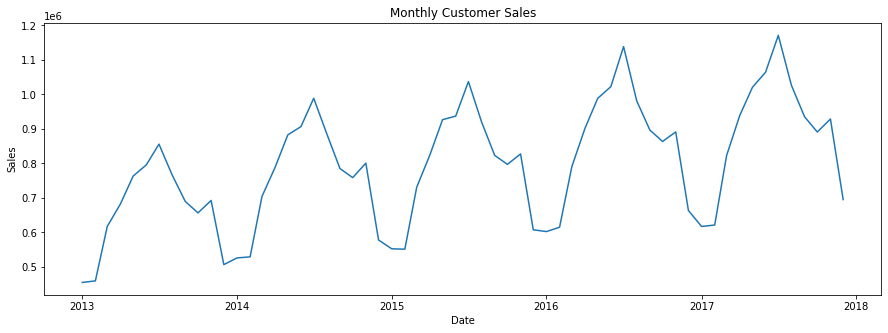

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales']) #sales is y axis and date is x axis
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

call the difference on the sales columns to make the sales data stationary 

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


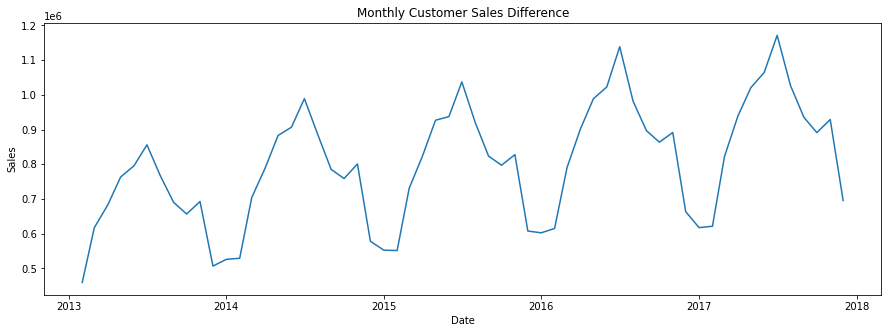

In [ ]:
plt.figure(figsize=(15,5)) #dimensions of 15 and 5
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()


Need to train models to predict sale of items in next month using previous month
Need to keep lookback month value is 12, so using last years of sales to predict

Dropping off sales and date

In [ ]:
supervised_data = monthly_sales.drop(['date','sales'], axis=1)


prepare it so 12 months previous sales is input, and next 12 months is the output for our supervised learning models, so we will iterate over 1 to 13 inclusive, so 1 to 12

This gives january to december, the sales differences and the 10 rows because we defined that. The sales difference is for each store based on each month. 

In [ ]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name]  = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Now we will split the data into Train and Test

In [ ]:
train_data =  supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


use min max scalar, to scale feature values to put them in range -1 to 1

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
# now we will fit train_data in the scaler

scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
# in supervised data frame, the first column always corresponds to the output and remaining columns are input features

In [ ]:
X_train, y_train = train_data[:,1:], train_data[:,0:1] 
X_test, y_test = test_data[:,1:], test_data[:,0:1] 
# in x or y test, first column is always output
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


Last step of data pre-processing is to make a prediction data frame to merge predictive sale price of all trained algorithms

In [ ]:
# get sales dates

sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)


Need to extract monthly sales values of last 13 months since they correspond to test data set, and these values will be used to find predicted sales prices from the predict output 

In [ ]:
actual_sales = monthly_sales['sales'][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


linear regression finds linear relationship between input variables and output variable. To train linear regression, we use scikit learn package. 

To create the linear regression model, and predicted output: 

In [ ]:
#initialize linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

In [ ]:
lr_predict = lr_predict.reshape(-1,1) # create linear regression prediction and reshaped it
# this is a set matrix - contains input features of the test data and also the predicted output 
lr_predict_test_set = np.concatenate([lr_predict, X_test], axis=1) #then created test set for the linear regression prediction model and concatenated prediction and x test
lr_predict_test_set = scaler.inverse_transform(lr_predict_test_set) #then used min max scaler to inverse transform linear regression test set 


Calculate predicted sale values 

In [ ]:
result_list = []
for index in range(0, len(lr_predict_test_set)):
  result_list.append(lr_predict_test_set[index][0] + actual_sales[index])
lr_predict_series = pd.Series(result_list, name="Linear Prediction")
#predict dataframe will merge linear regression prediction series where left index is true and right index is also true
predict_dataframe = predict_df.merge(lr_predict_series, left_index=True, right_index=True)

Since we have now calculated the predicted sale values of the test data we can now evaluate various metrics for the linear regression model. We want to compare to see variations and differences.

In [ ]:
#will use mean squared error, mean absolute error, and r2 score
lr_mean_squared_error = np.sqrt(mean_squared_error(predict_dataframe['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mean_absolute_error = mean_absolute_error(predict_dataframe['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_dataframe['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression Mean Squared Error: ", lr_mean_squared_error)
print("Linear Regression Mean Absolute Error: ", lr_mean_absolute_error)
print("Linear Regression R2 Score: ", lr_r2)

Linear Regression Mean Squared Error:  16221.272385416869
Linear Regression Mean Absolute Error:  12433.184266490736
Linear Regression R2 Score:  0.9906152516380969


Lets visualize the prediction against the actual sales

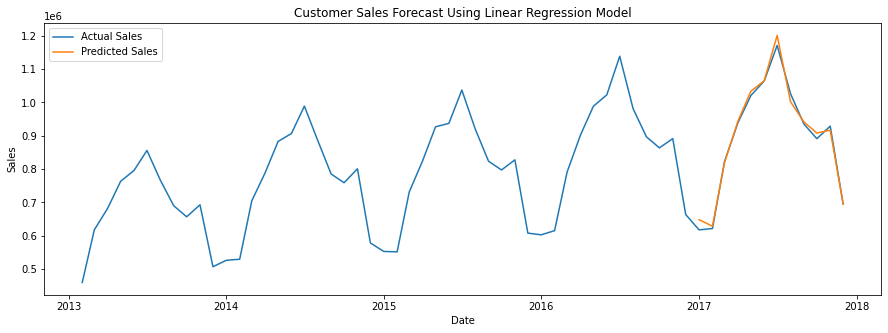

In [ ]:
plt.figure(figsize=(15,5))
#actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales']) 
#predicted sales
plt.plot(predict_dataframe['date'], predict_dataframe['Linear Prediction']) #Using 'Linear Prediction' is important!
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()

The predicted sales are only from 2017 to 2018